In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
import os, sys
from glob import glob
from os.path import join, isfile
import numpy as np
import pandas as pd

import time
from datetime import datetime
from copy import deepcopy

from sklearn.metrics import balanced_accuracy_score, roc_auc_score, get_scorer, make_scorer, confusion_matrix
from sklearn.feature_selection import SelectKBest, VarianceThreshold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import ParameterGrid, StratifiedKFold

from imblearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB

from joblib import Parallel, delayed, dump, load

# Local imports
from MLpipeline import *
from confounds import *

In [3]:
# Define settings for the experiment 
DATA_DIR = "/ritter/share/data/IMAGEN"

## Permutation tests
# Total number of permutation tests to run. Set to 0 to not perform any permutations. 
N_PERMUTATIONS = 1000
N_JOBS = 30 # parallel jobs
PARALLELIZE = False # within each MLPipeline trial, do you want to parallelize the permutation test runs too?
# if set to true it will run 1 trial with no parallel jobs and enables debug msgs
DEBUG = False
    
if DEBUG:
    if N_PERMUTATIONS > 2:
        N_PERMUTATIONS = 2
    N_JOBS = 1 
    PARALLELIZE = False

In [4]:
dirs = ['newlbls-bl-*', 'newlbls-fu2-*', 'newlbls-fu3-*']

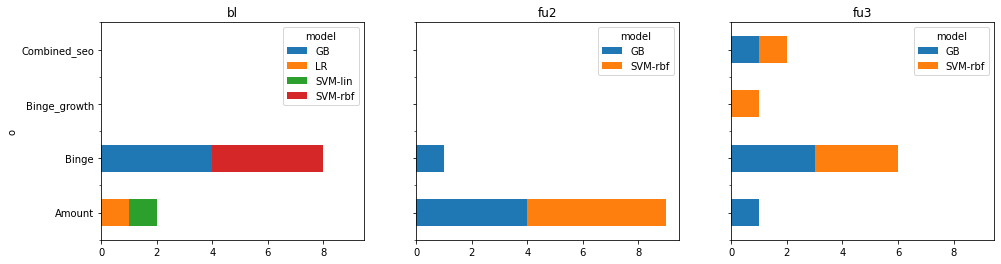

,o,model,trial,test_score,valid_score,train_score,roc_auc,model_LR__C,model_SVM-rbf__C,model_SVM-rbf__gamma,model_SVM-lin__C,model_GB__learning_rate,path,path_type
0,Binge,SVM-rbf,2,0.712907,0.685749,0.902663,0.809451,NaN,1000.0,scale,NaN,NaN,results/newlbls-bl-espad-fu3-19a-binge-n620/20...,bl
1,Binge,SVM-rbf,0,0.702490,0.695904,0.896246,0.795732,NaN,1000.0,scale,NaN,NaN,results/newlbls-bl-espad-fu3-19a-binge-n620/20...,bl
2,Binge,SVM-rbf,3,0.709350,0.676636,0.901826,0.791667,NaN,1000.0,scale,NaN,NaN,results/newlbls-bl-espad-fu3-19a-binge-n620/20...,bl
3,Binge,GB,2,0.697409,0.655082,0.974059,0.782520,NaN,NaN,NaN,NaN,0.25,results/newlbls-bl-espad-fu3-19a-binge-n620/20...,bl
4,Binge,GB,0,0.739075,0.699310,0.986958,0.782012,NaN,NaN,NaN,NaN,0.25,results/newlbls-bl-espad-fu3-19a-binge-n620/20...,bl
5,Binge,SVM-rbf,6,0.684743,0.691472,0.907716,0.778412,NaN,1.0,auto,NaN,NaN,results/newlbls-bl-espad-fu3-19a-binge-n620/20...,bl
6,Binge,GB,6,0.744162,0.671711,0.977690,0.771666,NaN,NaN,NaN,NaN,0.05,results/newlbls-bl-espad-fu3-19a-binge-n620/20...,bl
7,Binge,GB,3,0.731961,0.694912,0.979929,0.755081,NaN,NaN,NaN,NaN,0.25,results/newlbls-bl-espad-fu3-19a-binge-n620/20...,bl
8,Amount,LR,1,0.672692,0.557844,0.923934,0.749166,100.0,NaN,NaN,NaN,NaN,results/newlbls-bl-espad-fu3-prev31-amount-n62...,bl
9,Amount,SVM-lin,1,0.691046,0.562922,0.920451,0.746941,NaN,NaN,NaN,1000.0,NaN,results/newlbls-bl-espad-fu3-prev31-amount-n62...,bl


In [8]:

sort_by = "roc_auc"  #"roc_auc" #
best_results = pd.DataFrame()
fig, axes = plt.subplots(1,3, sharex=True, sharey=True, figsize=(16,4))

for i,each_dir in enumerate(dirs):
    
    results = pd.DataFrame()
    for f in glob(f"results/{each_dir}/*/run.csv"):
        run = pd.read_csv(f)
        run = run[~(run.o_is_conf) & ~(run.i_is_conf) & (run.technique=='cb')]
        run["path"] = f.replace("/run.csv", "")
        results = pd.concat([results, run])

    # results = results.sort_values("test_score", ascending=False)
    results = results.sort_values(sort_by, ascending=False).iloc[:10]
    hyper_cols = results.filter(like="model_").columns
    results = results.filter(items=["o", "model", "trial", "test_score", "valid_score", "train_score", "roc_auc", *hyper_cols, "path"])
    results["path_type"]= each_dir.replace("new", "").replace("lbls-", "").replace("*", "").replace("-", "")
    results[["o", "model"]].value_counts().unstack().plot.barh(stacked=True, title=results["path_type"].iloc[0], ax=axes[i])
    best_results = pd.concat([best_results, results])

plt.show()

best_results = best_results.reset_index(drop=True)
best_results#.sort_values(["path_type", sort_by], ascending=False)

<AxesSubplot:ylabel='o'>

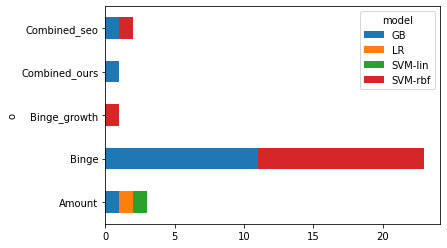

In [9]:
best_results[["o", "model"]].value_counts().unstack().plot.barh(stacked=True)

In [17]:
from slugify import slugify

best_results["holdout_score"] = np.nan
best_results["holdout_roc_auc"] = np.nan

print("========================================")
start_time = datetime.now()
print("time: ", start_time)

for k, row in best_results.iterrows():
    
    tp = row.path_type
    print(f"Testing ML model from: {row.path}")
    
    # load the trained model
    model = load(f"{row.path}/{row.model}_{row.trial}.model")
    
    # load the training data    
    h5_path = "/ritter/share/data/IMAGEN/h5files/{}.h5".format(row.path.split('/')[-2])
    data = h5py.File(h5_path, "r")
    X = data['X'][()]
    y_name = data.attrs['labels'][0]
    y = data[y_name][()]    
    confs = {}
    for c in data.attrs['confs']:
        confs[c] = np.array(data[c]) 
        
    # load the holdout data 
    y_name_h5 = slugify(y_name)
    if y_name_h5 == "audit": y_name_h5+="-total"
        
    test_h5_path = sorted(glob("/ritter/share/data/IMAGEN/h5files/newholdout-{}*{}*.h5".format(tp, y_name_h5)))
    assert ((len(test_h5_path)==1) or ("binge" in y_name_h5)), "for label {}, multiple test set files found: {}".format(slugify(y_name), test_h5_path)
    h5_path_holdout = test_h5_path[0]
    test_data = h5py.File(h5_path_holdout, "r")
    
    X_test = test_data['X'][()]
    y_test = test_data[y_name][()]    
#     print("n(train_data) = {}\t n(test_data)={} \t n(features) = {}".format(len(X), len(X_test), X.shape[-1]))
    model.steps[-2][-1].random_state = None
#     display(model)

    # prepare confound-correction params
    confs_grouped = np.array([])
    for c, v in confs.items():               
        if confs_grouped.size == 0:
            confs_grouped = v
        else:
            confs_grouped = 100*confs_grouped + v
            
    conf_corr_params={"conf_corr_cb__groups": confs_grouped}
    # retrain on entire data
    model = model.fit(X, y, **conf_corr_params)
    
    test_score = make_scorer(balanced_accuracy_score)(model, X_test, y_test)  
    # Calculate AUC if label is binary       
    roc_auc = get_scorer("roc_auc")(model, X_test, y_test)  
    
    
    best_results.loc[k, "holdout_score"] = test_score    
    best_results.loc[k, "holdout_roc_auc"] = roc_auc  
    print("training accuracy: {:0.2f}% \t holdout accuracy: {:0.2f}% \t holdout AUC ROC: {:0.2f}%".format(
         make_scorer(balanced_accuracy_score)(model, X, y)*100, test_score*100, roc_auc*100))

runtime=str(datetime.now()-start_time).split(".")[0]
print("TOTAL RUNTIME: {} secs".format(runtime))

time:  2021-07-14 16:45:54.083555
Testing ML model from: results/newlbls-bl-espad-fu3-19a-binge-n620/20210618-1632
training accuracy: 97.85% 	 holdout accuracy: 70.38% 	 holdout AUC ROC: 80.37%
Testing ML model from: results/newlbls-bl-espad-fu3-19a-binge-n620/20210618-1632
training accuracy: 98.00% 	 holdout accuracy: 70.38% 	 holdout AUC ROC: 79.50%
Testing ML model from: results/newlbls-bl-espad-fu3-19a-binge-n620/20210618-1632
training accuracy: 98.00% 	 holdout accuracy: 74.93% 	 holdout AUC ROC: 80.57%
Testing ML model from: results/newlbls-bl-espad-fu3-19a-binge-n620/20210618-1632


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 97.73% 	 holdout accuracy: 77.67% 	 holdout AUC ROC: 84.43%
Testing ML model from: results/newlbls-bl-espad-fu3-19a-binge-n620/20210618-1632


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 98.03% 	 holdout accuracy: 73.24% 	 holdout AUC ROC: 80.41%
Testing ML model from: results/newlbls-bl-espad-fu3-19a-binge-n620/20210618-1632
training accuracy: 96.33% 	 holdout accuracy: 71.54% 	 holdout AUC ROC: 78.08%
Testing ML model from: results/newlbls-bl-espad-fu3-19a-binge-n620/20210618-1632


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 98.85% 	 holdout accuracy: 78.20% 	 holdout AUC ROC: 81.91%
Testing ML model from: results/newlbls-bl-espad-fu3-19a-binge-n620/20210618-1632


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 98.00% 	 holdout accuracy: 74.18% 	 holdout AUC ROC: 81.87%
Testing ML model from: results/newlbls-bl-espad-fu3-prev31-amount-n620/20210618-1640
training accuracy: 97.55% 	 holdout accuracy: 48.82% 	 holdout AUC ROC: 56.73%
Testing ML model from: results/newlbls-bl-espad-fu3-prev31-amount-n620/20210618-1640


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


training accuracy: 97.32% 	 holdout accuracy: 55.56% 	 holdout AUC ROC: 57.07%
Testing ML model from: results/newlbls-fu2-espad-fu3-19a-binge-n634/20210618-1701
training accuracy: 99.14% 	 holdout accuracy: 78.73% 	 holdout AUC ROC: 84.12%
Testing ML model from: results/newlbls-fu2-espad-fu3-19a-binge-n634/20210618-1701
training accuracy: 98.44% 	 holdout accuracy: 75.25% 	 holdout AUC ROC: 83.80%
Testing ML model from: results/newlbls-fu2-espad-fu3-19a-binge-n634/20210618-1701
training accuracy: 98.15% 	 holdout accuracy: 80.74% 	 holdout AUC ROC: 85.22%
Testing ML model from: results/newlbls-fu2-espad-fu3-19a-binge-n634/20210618-1701
training accuracy: 98.24% 	 holdout accuracy: 77.04% 	 holdout AUC ROC: 84.59%
Testing ML model from: results/newlbls-fu2-espad-fu3-19a-binge-n634/20210618-1701
training accuracy: 98.93% 	 holdout accuracy: 80.74% 	 holdout AUC ROC: 84.51%
Testing ML model from: results/newlbls-fu2-espad-fu3-19a-binge-n634/20210618-1701


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 99.14% 	 holdout accuracy: 77.36% 	 holdout AUC ROC: 83.17%
Testing ML model from: results/newlbls-fu2-espad-fu3-19a-binge-n634/20210618-1701


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 98.18% 	 holdout accuracy: 69.94% 	 holdout AUC ROC: 77.34%
Testing ML model from: results/newlbls-fu2-espad-fu3-19a-binge-n634/20210618-1701


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 98.96% 	 holdout accuracy: 73.33% 	 holdout AUC ROC: 82.93%
Testing ML model from: results/newlbls-fu2-espad-fu3-19a-binge-n634/20210618-1701


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 99.08% 	 holdout accuracy: 76.51% 	 holdout AUC ROC: 82.93%
Testing ML model from: results/newlbls-fu2-our-combo-cluster-combined-ours-n745/20210618-1715


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 98.02% 	 holdout accuracy: 64.72% 	 holdout AUC ROC: 65.73%
Testing ML model from: results/newlbls-fu3-espad-fu3-19a-binge-n650/20210618-1730
training accuracy: 97.09% 	 holdout accuracy: 80.74% 	 holdout AUC ROC: 84.00%
Testing ML model from: results/newlbls-fu3-phenotype-phenotype-combined-seo-n589/20210618-1747
training accuracy: 95.73% 	 holdout accuracy: 65.17% 	 holdout AUC ROC: 72.20%
Testing ML model from: results/newlbls-fu3-phenotype-phenotype-combined-seo-n589/20210618-1747


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 96.33% 	 holdout accuracy: 60.94% 	 holdout AUC ROC: 67.39%
Testing ML model from: results/newlbls-fu3-espad-gm-fine-cluster-binge-growth-n642/20210618-1741
training accuracy: 96.74% 	 holdout accuracy: 69.14% 	 holdout AUC ROC: 76.96%
Testing ML model from: results/newlbls-fu3-espad-fu3-19a-binge-n650/20210618-1730


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 99.51% 	 holdout accuracy: 79.27% 	 holdout AUC ROC: 84.90%
Testing ML model from: results/newlbls-fu3-espad-fu3-19a-binge-n650/20210618-1730
training accuracy: 97.17% 	 holdout accuracy: 76.41% 	 holdout AUC ROC: 83.01%
Testing ML model from: results/newlbls-fu3-espad-fu3-19a-binge-n650/20210618-1730


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 98.48% 	 holdout accuracy: 73.24% 	 holdout AUC ROC: 81.79%
Testing ML model from: results/newlbls-fu3-espad-fu3-prev31-amount-n651/20210618-1739


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 96.90% 	 holdout accuracy: 58.67% 	 holdout AUC ROC: 59.20%
Testing ML model from: results/newlbls-fu3-espad-fu3-19a-binge-n650/20210618-1730
training accuracy: 98.79% 	 holdout accuracy: 77.89% 	 holdout AUC ROC: 84.47%
Testing ML model from: results/newlbls-fu3-espad-fu3-19a-binge-n650/20210618-1730


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training accuracy: 98.75% 	 holdout accuracy: 70.38% 	 holdout AUC ROC: 78.99%
TOTAL RUNTIME: 0:00:36 secs


In [18]:
# best_results.to_csv("holdout_results.csv")

In [25]:
best_results_plot = pd.DataFrame(columns=best_results.columns)
for tp, grp in best_results.groupby("path_type"):
#     best = grp.sort_values(["holdout_score"], ascending=False)#.iloc[:3]
    best = grp#[grp["model"].isin(["SVM-rbf"]) & grp["o"].isin(["Binge"])].sort_values(["holdout_score"], ascending=False)#.iloc[:3]  #~grp["o"].isin(["Frequency", "onset<15"])
    best_results_plot = pd.concat([best_results_plot, best])

In [26]:
# best_results_plot.model.value_counts()

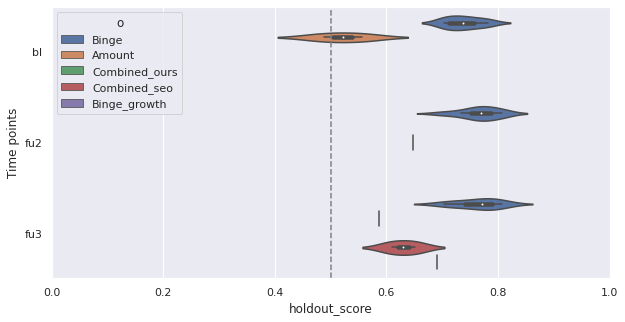

In [27]:
sns.set(rc={'figure.figsize':(10,5)})
ax = sns.violinplot(x="holdout_score", y="path_type", hue="o",
            data=best_results_plot)
ax.set_xlim(0.0, 1.0)
ax.set_ylabel("Time points")
ax.axvline(0.5, label="chance", c='gray', ls='--', lw=1.5)

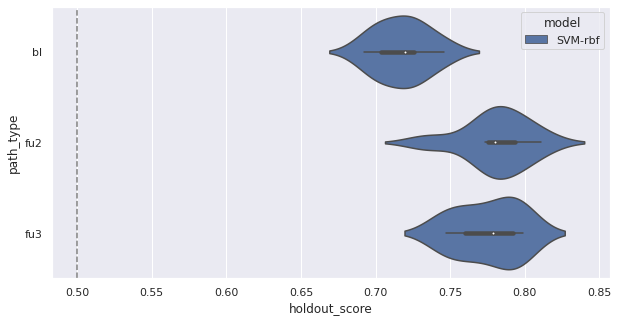

In [58]:
sns.set(rc={'figure.figsize':(10,5)})
ax = sns.violinplot(x="holdout_score", y="path_type", hue="model",
            data=best_results_plot)
ax.axvline(0.5, label="chance", c='gray', ls='--', lw=1.5)

### testing for runMLtest.py

In [8]:
import os, sys
from glob import glob
from os.path import join, isfile
import numpy as np
import pandas as pd

import time
from datetime import datetime
from copy import deepcopy

from sklearn.metrics import balanced_accuracy_score, roc_auc_score, get_scorer, make_scorer

from joblib import Parallel, delayed, dump, load

# Local imports
from MLpipeline import *
from confounds import *
from slugify import slugify
import warnings
warnings.simplefilter("ignore", UserWarning) ## ignore the warning XGB is throwning

# Define settings for the experiment 
DATA_DIR = "/ritter/share/data/IMAGEN"
H5_FILES_PATH = "/ritter/share/data/IMAGEN/h5files"
## Permutation tests
# Total number of permutation tests to run. Set to 0 to not perform any permutations. 
N_PERMUTATIONS = 0
N_JOBS = 2 # parallel jobs
PARALLELIZE = False # within each MLPipeline trial, do you want to parallelize the permutation test runs too?
# if set to true it will run 1 trial with no parallel jobs and enables debug msgs
DEBUG = True
    
# directories of all 3 timepoints
tp_dirs = ['newlbls-bl-espad-fu3-19a-binge-n620/20210618-1632',
           'newlbls-fu2-espad-fu3-19a-binge-n634/20210618-1701', 
           'newlbls-fu3-espad-fu3-19a-binge-n650/20210618-1730'] #todo site# :: 'across_sites/lbls-bl-*'
HOLDOUT_DIR = "/ritter/share/data/IMAGEN/h5files/newholdout-{}*{}*.h5" #todo site# newholdout:: h5files/holdout-
SAVE_PATH = "results/holdout_all-tp-extra_run.csv" #todo site# #holdout_results :: holdout_results_sites 
EXTRA_INFERENCE_DIR = False# "/ritter/share/data/IMAGEN/h5files/mediumextras-{}*{}*.h5"

if DEBUG:
    if N_PERMUTATIONS > 2: N_PERMUTATIONS = 2
    N_JOBS = 1 
    PARALLELIZE = False
    tp_dirs=[tp_dirs[0]]
    EXTRA_INFERENCE_DIR = False

In [ ]:
##### Load all run.csv files from each dir  #####
df_runs = []
for i, each_dir in enumerate(tp_dirs):
    # first, collect all run.csv results together
    f = glob(f"results/{each_dir}/run.csv")
    assert len(f)==1, f"multiple result folders found with {each_dir} = {f}"
    f = f[0]
    run = pd.read_csv(f)
    # select only 'cb' controlled results and drop the confound-related rows
    run = run[~(run.o_is_conf) & ~(run.i_is_conf) & (run.technique=='cb')]
    # add a column about the source h5 file
    run["path"] = f.replace("/run.csv", '')
    # add a column about the tp in the source h5 file  
    tp = each_dir.lower().split('-')[1]
    assert tp in ["bl", "fu2", "fu3"]
    run["tp"] = tp
    df_runs.extend([run])

df_runs = pd.concat(df_runs).reset_index(drop=True)
print("running inference  on the holdout set with {} models (3 tps X 4 models X 7 folds) with {} permutation tests in each".format(len(df_runs), N_PERMUTATIONS))

# get the hyperparameters values to do a gridsearchCV for
model_grids = { model:
        { hparam: df_runs[hparam].dropna().unique().tolist() 
         for hparam in df_runs.filter(like=f"model_{model}__")} 
        for model in ['LR','SVM-lin','SVM-rbf','GB']}

In [ ]:
##### Initialize new columns to store results from holdout #####
for c in ["holdout_score", "holdout_roc_auc",
          "holdout_ids", "holdout_lbls","holdout_probs",
          "permuted_holdout_score", "holdout_permuted_roc_auc",
          "holdout_ids_extra", "holdout_probs_extra"
         ]:
    df_runs[c] = np.nan
    df_runs[c] = df_runs[c].astype('object')

print("========================================")
start_time = datetime.now()
print("time: ", start_time)


data_reload_flag = ''

for k, row in df_runs.iterrows():
    # if debug mode then only run 1 in 3 experiments at random
    if DEBUG and k and np.random.choice([True, True, False]):  continue
            
    if data_reload_flag != row.path: # reload the data and MLpipeline only if the data to be used changed
        data_reload_flag = row.path
        
        # 1) load MLpipeline class (with a random seed)
        m = MLpipeline(PARALLELIZE, 
                       random_state=np.random.randint(100000), 
                       debug=DEBUG)
    
        # 2) load the training data    
        print("------------------------------------------------------------------")
        h5_path = join(H5_FILES_PATH, "{}.h5".format(row.path.split('/')[-2]))
        print(f"Training data path: \t\t{h5_path}")
        m.load_data(h5_path, y=row.o, confs=['sex', 'site'], group_confs=True)
        
        # 3) load the holdout data and simulate the MLpipeline.train_test_split() func
        y_name_h5 = slugify(row.o)
        if y_name_h5 == "audit": y_name_h5+="-total"
        test_h5_path = sorted(glob(HOLDOUT_DIR.format(row.tp, y_name_h5))) 
        assert ((len(test_h5_path)==1) or ("binge" in y_name_h5)), "for label {}, multiple test set files found: {}".format(slugify(y_name), test_h5_path)

        h5_path_holdout = test_h5_path[0]
        print(f"Testing data path: \t\t{h5_path_holdout}")
        test_data = h5py.File(h5_path_holdout, "r")  

        m.X_test = test_data['X'][()]
        m.y_test = test_data[row.o][()]  
        m.sub_ids_test = test_data['i'][()]
        for c in m.confs:
            if c != 'group': 
                m.confs_test[c] = test_data[c][()]
                # manually redo confs grouping
                v = test_data[c][()]
                if "group" not in m.confs_test:
                    m.confs_test["group"] = v
                else:
                    m.confs_test["group"] = v + 100*m.confs_test["group"]
                
        m.n_samples_tv = len(m.y)
        m.n_samples_test = len(m.y_test)
        
        m.print_data_size()
    
    # 3) Load the trained model
    model_path = f"{row.path}/{row.model}_{row.trial}.model"
    print(f"ML model (retraining): \t{model_path}")
    
    model = load(model_path)
    
    # 4) run the retraining & hyperparameter tuning and generate report
    report = m.run(model, grid=model_grids[row.model], 
                   n_splits=5, conf_corr_params={"conf_corr_cb__groups": m.confs["group"]}, 
                   permute=N_PERMUTATIONS, verbose=1)
    
    print("train_score: {:0.2f}% \t valid_score: {:0.2f}% \t holdout_score: {:0.2f}".format(
     report['train_score']*100, report['valid_score']*100, report['test_score']*100))
    
    # store the results in the same dataframe dfIrun
    for key, val in report.items():
        # rename the report columns to have 'holdout'
        new_key = 'holdout_'+ key if 'test' not in key else key.replace('test','holdout')
        df_runs.at[k, new_key]  = val
    

    if EXTRA_INFERENCE_DIR:
        print("running extra inference also on some (unlabeled) subjects at:\n", EXTRA_INFERENCE_DIR)

        extra_h5_path = sorted(glob(EXTRA_INFERENCE_DIR.format(row.tp, y_name_h5))) 
        assert ((len(extra_h5_path)==1) or ("binge" in y_name_h5)), "for label {}, multiple test set files found: {}".format(slugify(row.o), extra_h5_path)

        extra_h5_path = extra_h5_path[0]
        extra_data = h5py.File(extra_h5_path, "r")
        df_runs.at[k, "holdout_ids_extra"]   = extra_data['i'][()].tolist()

        X_extra = extra_data['X'][()]  
        preds = np.around(model.predict_proba(X_extra), decimals=4)
        df_runs.at[k, "holdout_probs_extra"]  = preds.tolist()

runs.to_csv(SAVE_PATH) 

# print the total runtime
runtime=str(datetime.now()-start_time).split(".")[0]
print("TOTAL RUNTIME: {} secs".format(runtime))